In [1]:
import datetime
import os
import numpy as np
import pandas as pd
import seaborn as sns
from netCDF4 import Dataset


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


import matplotlib.pyplot as plt

# 1
## a)
Lets start by visualizing our data at a few different time steps to get a good idea of what we are working with.

dict_keys(['longitude', 'latitude', 'level', 'time', 'z'])


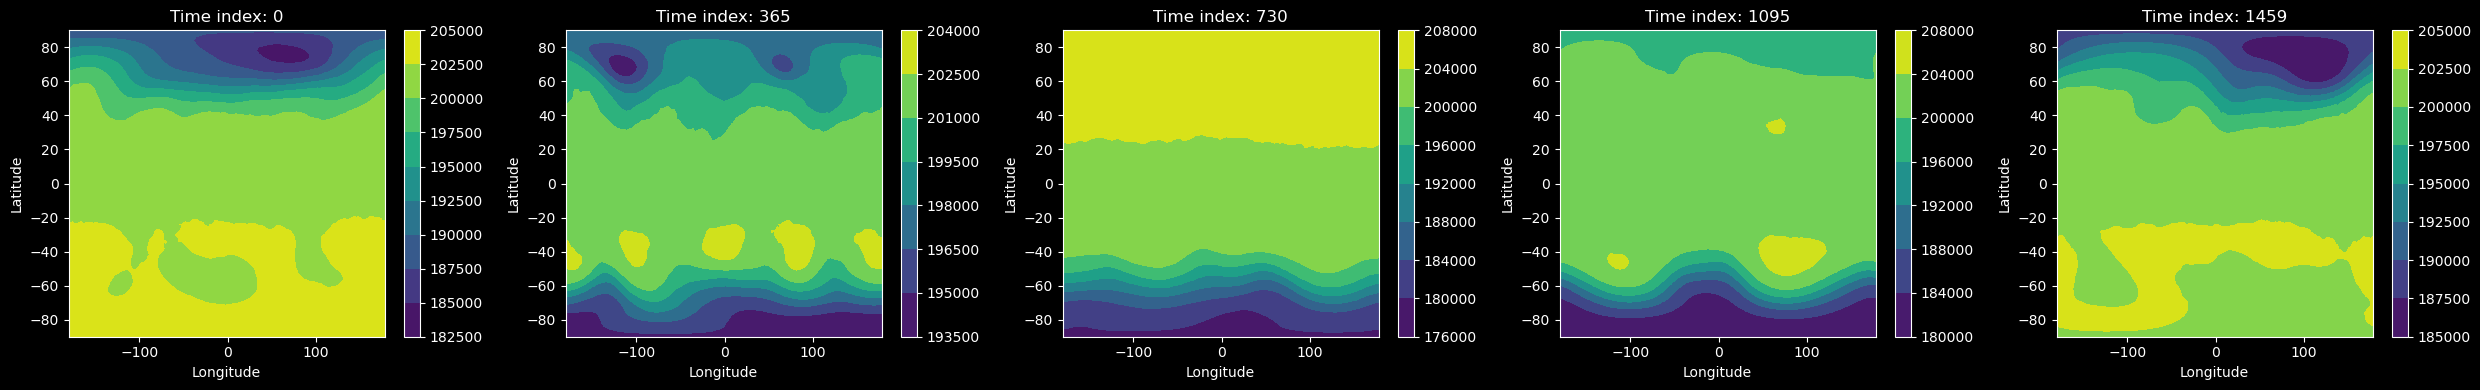

In [2]:
# load datasets for each year
z1979 = Dataset('z1979.nc', 'r')
z1980 = Dataset('z1980.nc', 'r')
z1981 = Dataset('z1981.nc', 'r')
z1983 = Dataset('z1983.nc', 'r')
z1985 = Dataset('z1985.nc', 'r')

# print the keys
print(z1979.variables.keys())
# z1979 = z1979.variables['z'][:]
# (1460, 2, 91, 180)
# time × channel × latitude × longitude.

# Extract the variable 'z' (shape: time × channel × latitude × longitude)
z = z1979.variables['z'][:]  # shape (1460, 2, 91, 180)

# Extract coordinate arrays for latitude and longitude.
# Adjust these variable names if they are different in your file.
lat = z1979.variables['latitude'][:]  # shape (91,)
lon = z1979.variables['longitude'][:]  # shape (180,)

# Define time indices to plot (sampled every 6 hours, so indices correspond to 6-hour intervals)
time_indices = [0, 365, 730, 1095, 1459]

# Create a meshgrid for contour plotting (lon along x-axis, lat along y-axis)
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Create a figure with subplots (one per selected time step)
fig, axes = plt.subplots(nrows=1, ncols=len(time_indices), figsize=(5 * len(time_indices), 4))

# In case only one time step is selected, ensure axes is a list.
if len(time_indices) == 1:
    axes = [axes]

for ax, t_idx in zip(axes, time_indices):
    # Extract the data for the given time and the first channel.
    # The slice will have shape: (latitude, longitude)
    z_slice = z[t_idx, 0, :, :]  # Using NumPy indexing

    # Create a contour plot with the given coordinate grid and data
    cs = ax.contourf(lon_grid, lat_grid, z_slice, cmap='viridis')

    # Add title and labels for clarity
    ax.set_title(f"Time index: {t_idx}")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Add a colorbar for the contour plot
    fig.colorbar(cs, ax=ax, orientation='vertical')

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

## B)
Now that we've visualized the data lets build a **denoising variational autoencoder**, first we define our training and testing data. and normalize it so it can be learned by the model better.

In [3]:
# Concatenate arrays along the time dimension 
training_data = np.concatenate([
    z1979.variables['z'][:],
    z1980.variables['z'][:],
    z1981.variables['z'][:],
    z1983.variables['z'][:]
], axis=0)

testing_data = z1985.variables['z'][:]
print(training_data.shape)
print(testing_data.shape)

data_mean = np.mean(training_data)
data_std = np.std(training_data)
print(f"Data mean: {data_mean}, Data std: {data_std}")

train_data_norm = (training_data - data_mean) / data_std
test_data_norm = (testing_data - data_mean) / data_std


(5844, 2, 91, 180)
(1460, 2, 91, 180)
Data mean: 126784.00788396952, Data std: 72895.64795856815


Now we corrupt our data by adding sparicity to it setting k random points to zero at each time step where k is a hyperparameter that we can tune. We will use 3 different values of k to see how it affects the model. k = 30%, 60%, 90%.

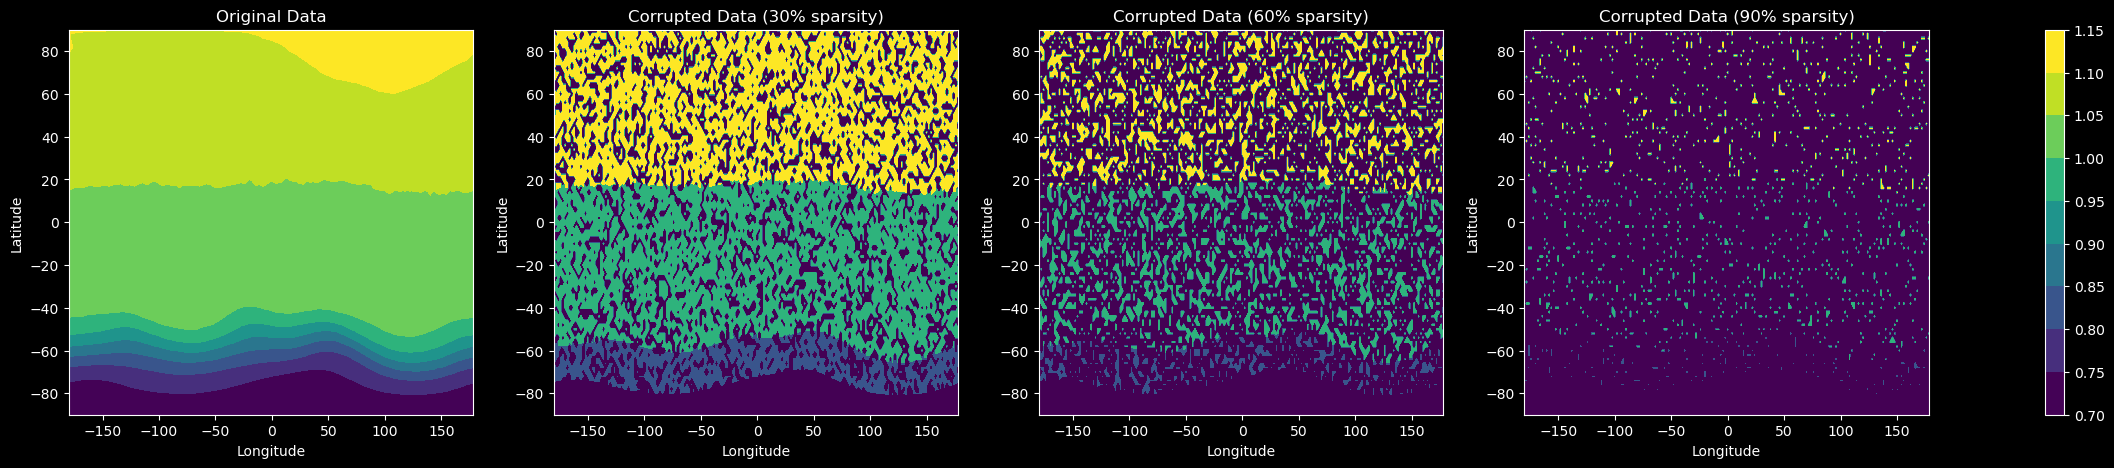

In [4]:
def sparsify(data, k, seed=None):
    """
    Generate an X_c sample given the original data X. by setting a random k% of the spatial points to zero for every time step, and every channel.
    
    Args:
        data: numpy array with shape (time, channel, latitude, longitude)
        k: percent of data to set to zero
        seed: random seed for reproducibility
        
    Returns:
        Corrupted data with the same shape as the input (X_c)
    """
    if seed is not None:
        np.random.seed(seed)
    
    corrupted_data = data.copy()
    time_steps, channels, lat_dim, lon_dim = data.shape
    total_spatial_points = lat_dim * lon_dim
    
    # calculate the number of spatial points to set to zero
    k = int(k / 100 * total_spatial_points)
    
    for t in range(time_steps):
        # Generate k random indices in the spatial domain
        flat_indices = np.random.choice(total_spatial_points, size=k, replace=False)
        
        # Convert flat indices to 2D coordinates
        lat_indices = flat_indices // lon_dim
        lon_indices = flat_indices % lon_dim
        
        # Set values to zero for all channels
        for c in range(channels):
            corrupted_data[t, c, lat_indices, lon_indices] = 0
    
    return corrupted_data

# Apply corruption to training and testing data
lat_dim, lon_dim = train_data_norm.shape[2], train_data_norm.shape[3]
total_spatial_points = lat_dim * lon_dim

# we will make mutiple corrupted datasets with different sparsity levels
corrupted_datasets = []
sparsity_levels = [30, 60, 90] # 30%, 60%, and 90% sparsity

for k in sparsity_levels:
    corrupted_train = sparsify(train_data_norm, k, seed=42)
    corrupted_test = sparsify(test_data_norm, k, seed=42)
    
    corrupted_datasets.append((corrupted_train, corrupted_test))

# Visualize original vs corrupted data for a sample time step
t_idx = 730  # Sample time index

# Extract the latitude and longitude for plotting
lat = z1979.variables['latitude'][:]
lon = z1979.variables['longitude'][:]
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Create a figure with subplots (original vs corrupted for channel 0)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))

# Compute the color scale limits from the original data for consistency
vmin = train_data_norm[t_idx, 0, :, :].min()
vmax = train_data_norm[t_idx, 0, :, :].max()

cmap = 'viridis'

# Plot original data
cs_orig = axes[0].contourf(lon_grid, lat_grid, train_data_norm[t_idx, 0, :, :], cmap=cmap, vmin=vmin, vmax=vmax)
axes[0].set_title('Original Data')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot corrupted data at every sparsity level
for i, (k, (training_data_corrupted, _)) in enumerate(zip(sparsity_levels, corrupted_datasets)):
    cs_corr = axes[i+1].contourf(lon_grid, lat_grid, training_data_corrupted[t_idx, 0, :, :], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[i+1].set_title(f'Corrupted Data ({k}% sparsity)')
    axes[i+1].set_xlabel('Longitude')
    axes[i+1].set_ylabel('Latitude')

# shared colorbar
fig.colorbar(cs_orig, ax=axes, orientation='vertical')

# plt.tight_layout() # this breaks the layout for some reason
plt.show()

now all of our data is ready to be fed into the model. we will use a convolutional variational autoencoder to denoise the data. we will use 4 2d convolutional layers with a kernel size of 3x3 and a stride of 2. we will use a latent dimension of 2. we will use a batch size of 16 and train the model for 20 epochs. our encoder will upsample the data from 2 channels to 256 channels applying a leakly relu between each layer. our decoder will downsample the data from 256 channels to 2 channels also applying a leakly relu between each layer. we will use the adam optimizer with a learning rate of 0.001.

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, in_channels, input_shape=(2, 91, 180), latent_dim=128, device="cpu"):
        """
        Args:
            in_channels: number of input channels (expecting 2)
            input_shape: tuple representing (channels, lat, long) of the input expecting (2, 91, 180)
            latent_dim: dimension of the latent space
        """
        super(ConvVAE, self).__init__()
        self.input_shape = input_shape[1:]  # (lat, long)

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        ).to(device)
        
        # Dynamically compute the encoder output shape and size
        with torch.no_grad():
            sample_input = torch.zeros(1, *input_shape, device=device)
            sample_output = self.encoder(sample_input)
            self.encoded_shape = sample_output.shape[1:]  # (256, 6, 12)
            self.encoded_size = sample_output.numel()
        
        # Latent space layers
        self.fc_mu = nn.Linear(self.encoded_size, latent_dim)
        self.fc_logvar = nn.Linear(self.encoded_size, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.encoded_size)
        
        # Decoder (mirror the encoder)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        
    def encode(self, x):
        """Encode input to latent space"""
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        """Sample from latent space using reparameterization"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, z):
        """Decode from latent space to reconstruction"""
        z = self.fc_decode(z)
        z = z.view(z.size(0), *self.encoded_shape)
        x_recon = self.decoder(z)
        # Ensure the output matches the original input size
        if x_recon.shape[2:] != self.input_shape:
            x_recon = torch.nn.functional.interpolate(
                x_recon, size=self.input_shape, mode='bilinear', align_corners=False
            )
        return x_recon
        
    def forward(self, x):
        """Forward pass through VAE"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# Define loss function
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss function: reconstruction loss + KL divergence
    Args:
        recon_x: reconstructed data
        x: original data
        mu: mean of latent distribution
        logvar: log variance of latent distribution
        beta: weight of KL divergence term
    """
    # Reconstruction loss (MSE)
    recon_loss = torch.nn.functional.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    return recon_loss + beta * kl_loss

# Training function
def train_model(model, train_data, test_data, epochs=20, batch_size=16, lr=1e-3, device="cpu", sparsity_level=60):
    """Train the VAE model on the given data, with the specified training parameters."""
    print(f"Training model with {sparsity_level}% sparsity...")
    
    # Unpack data
    train_corrupted, train_original = train_data
    test_corrupted, test_original = test_data
    
    # Convert to torch tensors
    train_corrupted = torch.tensor(train_corrupted, dtype=torch.float32).to(device)
    train_original = torch.tensor(train_original, dtype=torch.float32).to(device)
    
    test_corrupted = torch.tensor(test_corrupted, dtype=torch.float32).to(device)
    test_original = torch.tensor(test_original, dtype=torch.float32).to(device)
    
    # Create DataLoader
    train_dataset = TensorDataset(train_corrupted, train_original)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Move model to device
    model = model.to(device)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    train_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        
        print(f"\nEpoch {epoch + 1}/{epochs}, learning rate: {lr}")
        
        if epoch > 10 and lr > 5e-4 and abs(train_losses[-1] - train_losses[-2]) < 1 and abs(train_losses[-3] - train_losses[-4]) < 1: # if the training stagnates for the last 2 epochs
            lr = 1e-4
            # decrease the learning rate after 10 if the loss epochs to get better convergence
            optimizer = optim.Adam(model.parameters(), lr=lr)
            print(f"loss stagnating, decreasing learning rate to {lr}")

        
        i = 0
        for batch_corrupted, batch_original in train_loader:
            # print(f"Batch {i+1}/{len(train_loader)}", end='\r') # this makes the output pretty but slows down the training
            i += 1
            
            optimizer.zero_grad()
            
            # Forward pass
            recon_batch, mu, logvar = model(batch_corrupted)
            
            # Calculate loss
            loss = vae_loss(recon_batch, batch_original, mu, logvar)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            if i % 100 == 0 or i == len(train_loader):
                print(f"  Batch {i}/{len(train_loader)}: Loss {loss.item():.2f}")
            # accumulate the per for the entire epoch
            train_loss += loss.item()
            
        avg_epoch_loss = train_loss / len(train_loader) # average loss per batch for the epoch
        train_losses.append(avg_epoch_loss)
        print(f"Loss this Epoch: {avg_epoch_loss:.2f}")
    
    return train_losses

In [6]:
# Define the list of sparsity levels that were used to generate the corrupted datasets
# sparsity_levels = [30, 60, 90]

# define the device
# device = torch.device("mps")

# if running in colab or nvida machine use cuda, otherwise use mps or cpu
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Training on device: {device}")

# initialize the model
model = ConvVAE(in_channels=2, input_shape=(2, 91, 180), latent_dim=128, device=device)

os.makedirs("loss", exist_ok=True)
os.makedirs("weights", exist_ok=True)

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


overall_loss = []

# Loop through each sparsity level, train the model, and save the weights
for k_idx, sparsity in enumerate(sparsity_levels):
    print(f"\nStarting training for sparsity level: {sparsity}%")
    
    # Select the corresponding corrupted training and testing data from the list
    corr_train, corr_test = corrupted_datasets[k_idx]
    print(f"Corrupted train shape: {corr_train.shape}, Corrupted test shape: {corr_test.shape}")
    
    # Prepare train and test tuples
    train = (corr_train, train_data_norm)
    test = (corr_test, test_data_norm)
    
    try:
        # Train the model. This function should run for the specified number of epochs.
        losses = train_model(model, train, test, epochs=20, device=device, lr=1e-3 ,sparsity_level=sparsity)
        overall_loss.append(losses)
    except Exception as e:
        print(f"An error occurred during training: {e}")
        continue
    
    try: 
        # Plot the training loss curve
        plt.figure()
        plt.yscale('log')
        plt.plot(range(1, len(losses)+1), losses, marker='o')
        plt.title(f"Training Loss Curve for {sparsity}% Sparsity")
        plt.xlabel("Epoch")
        plt.ylabel("Average Training Loss")
        plt.grid(True)
    
        loss_plot_filename = os.path.join("loss", f"loss_curve_{sparsity}percent_{timestamp}.png")
        plt.savefig(loss_plot_filename)
        plt.close()  # close the figure to free memory
        print(f"Saved training loss curve to {loss_plot_filename}")
    except Exception as e:
        print(f"An error occurred while saving the loss curve: {e}")

# we will do one more very brief training on the 0% sparsity / clean data
train = (train_data_norm, train_data_norm)
test = (test_data_norm, test_data_norm)

try:
    # Train the model. This function should only run for 5 epochs at a lower learning rate. or ~1/4-1/5 of the epochs of the other sparsity levels
    losses = train_model(model, train, test, epochs=7, device=device, lr=1e-4, sparsity_level=0)
    overall_loss.append(losses)
except Exception as e:
    print(f"An error occurred during training: {e}")
    
try: 
    # Plot the training loss curve
    plt.figure()
    plt.yscale('log')
    plt.plot(range(1, len(losses)+1), losses, marker='o')
    plt.title(f"Training Loss Curve for {0}% Sparsity")
    plt.xlabel("Epoch")
    plt.ylabel("Average Training Loss")
    plt.grid(True)

    loss_plot_filename = os.path.join("loss", f"loss_curve_{0}percent_{timestamp}.png")
    plt.savefig(loss_plot_filename)
    plt.close()  # close the figure to free memory
    print(f"Saved training loss curve to {loss_plot_filename}")
except Exception as e:
    print(f"An error occurred while saving the loss curve: {e}")

try: 
    # Save the model weights to a file with the appropriate name
    weight_filename = os.path.join("weights", f"convVAE_weights_{timestamp}.pth")
    torch.save(model.state_dict(), weight_filename)
    print(f"Saved model weights to {weight_filename}\n")
except Exception as e:
    print(f"An error occurred while saving the model weights: {e}")

Training on device: mps

Starting training for sparsity level: 30%
Corrupted train shape: (5844, 2, 91, 180), Corrupted test shape: (1460, 2, 91, 180)
Training model with 30% sparsity...

Epoch 1/20, learning rate: 0.001
  Batch 100/366: Loss 7211.63
  Batch 200/366: Loss 3747.45
  Batch 300/366: Loss 2973.95
  Batch 366/366: Loss 705.44
Loss this Epoch: 38666.14

Epoch 2/20, learning rate: 0.001
  Batch 100/366: Loss 3091.46
  Batch 200/366: Loss 2533.79
  Batch 300/366: Loss 2886.78
  Batch 366/366: Loss 606.40
Loss this Epoch: 2777.66

Epoch 3/20, learning rate: 0.001
  Batch 100/366: Loss 2035.51
  Batch 200/366: Loss 2500.95
  Batch 300/366: Loss 1847.23
  Batch 366/366: Loss 475.21
Loss this Epoch: 2252.00

Epoch 4/20, learning rate: 0.001
  Batch 100/366: Loss 1537.40
  Batch 200/366: Loss 1527.66
  Batch 300/366: Loss 1160.53
  Batch 366/366: Loss 361.27
Loss this Epoch: 1413.32

Epoch 5/20, learning rate: 0.001
  Batch 100/366: Loss 978.60
  Batch 200/366: Loss 867.25
  Batch 

Training complete.
(67,)


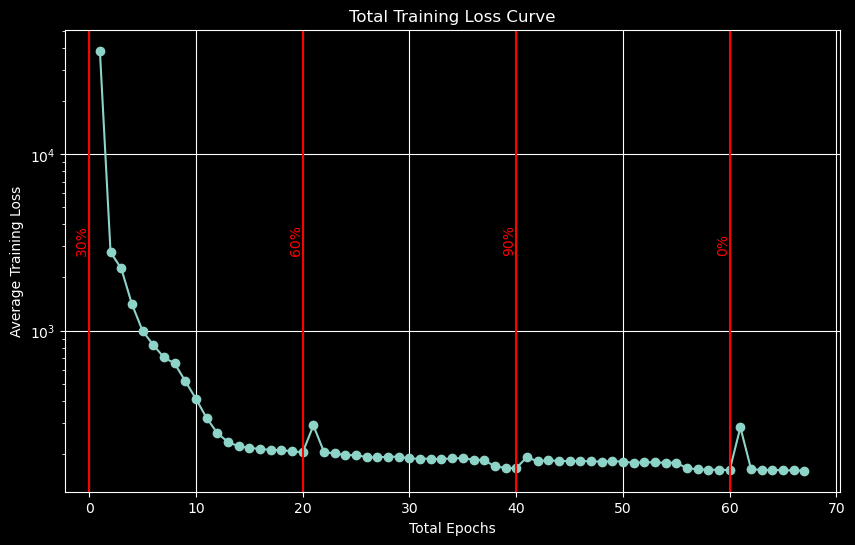

In [7]:
print("Training complete.")
flattened_losses = [loss for sublist in overall_loss for loss in sublist]
flattened_losses = np.array(flattened_losses)
print(flattened_losses.shape)

plt.figure(figsize=(10, 6))
plt.yscale('log')
plt.plot(range(1, len(flattened_losses) + 1), flattened_losses, marker='o')
plt.title("Total Training Loss Curve")
plt.xlabel("Total Epochs")
plt.ylabel("Average Training Loss")
plt.grid(True)

# Define phase change epochs and labels.
phase_changes = {0: "30%", 20: "60%", 40: "90%", 60: "0%"}

# Get current y-axis limits to help position text
ymin, ymax = plt.ylim()

for x, label in phase_changes.items():
    plt.axvline(x=x, color='red', linestyle='-')
    # Adjust the text position as needed; here we place the label at a fraction above ymin.
    plt.text(x, ymin + (ymax - ymin)*0.05, label, color='red', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontsize=10)

plt.savefig(f"loss/full_loss_curve{timestamp}.png")
plt.show()
plt.close()

Let's see how well our model reconstructs the data. by letting it process the testing data and plotting the original and reconstructed data.

In [8]:
# Evaluate the model on the test data and store samples
print(f"Evaluating on device: {device}")

# Convert test_data_norm to a PyTorch tensor on the chosen device
if isinstance(test_data_norm, torch.Tensor):
    # Already a tensor: make a safe copy (clone) and move to the device
    test_data_norm_torch = test_data_norm.clone().detach().to(device)
else:
    # Not a tensor (likely a NumPy array): convert it directly to a tensor on the device
    test_data_norm_torch = torch.tensor(test_data_norm, dtype=torch.float32, device=device)

# Initialize the model architecture (same as during training)
model = ConvVAE(
    in_channels=2, 
    input_shape=(2, 91, 180), 
    latent_dim=128, 
    device=device
)

# Load the final saved weights
weight_filename = os.path.join("weights", f"convvae_weights_{timestamp}.pth")
model.load_state_dict(torch.load(weight_filename, map_location=torch.device("cpu"), weights_only=True))
model.to(device)
print(f"Loaded model weights from {weight_filename}")

# Set model to evaluation mode
model.eval()

# Function to compute mean squared error (MSE)
def compute_mse(reconstructed, target):
    return ((reconstructed - target) ** 2).mean().item()

sample_idx = 0  # which sample in the batch to visualize/compare

# Dictionary to store the sample data at each sparsity
# key will be the sparsity level, value will be (original, reconstructed) tuple
sample_images = {}

# Evaluate on the "original" (0% sparsity) test data
with torch.no_grad():
    output = model(test_data_norm_torch)       # forward pass
    reconstructed = output[0]                  # model returns (recon, mu, logvar)
    mse_original = compute_mse(reconstructed, test_data_norm_torch)
print(f"MSE for  0% sparsity: {mse_original:.5f}")

# Extract a single sample from the batch for plotting
original_sample_0 = test_data_norm_torch[sample_idx].cpu().numpy().squeeze()
reconstructed_sample_0 = reconstructed[sample_idx].cpu().numpy().squeeze()

# Store (original, reconstruction) under sparsity=0
sample_images[0] = (original_sample_0, reconstructed_sample_0)

# Dictionary to store MSE for each sparsity level
mse_results = {0: mse_original}

# Evaluate on each sparsity level's corrupted test data
for k_idx, sparsity in enumerate(sparsity_levels):
    # corrupted_datasets[k_idx] = (corr_train, corr_test)
    _, corr_test = corrupted_datasets[k_idx]
    
    # Convert corrupted test data to tensor
    corr_test_torch = torch.tensor(corr_test, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        output = model(corr_test_torch)
        corrupted_reconstruction = output[0]
        
        # Compare reconstruction to the non corrupted test_data_norm_torch
        mse_corr = compute_mse(corrupted_reconstruction, test_data_norm_torch)
    mse_results[sparsity] = mse_corr
    print(f"MSE for {sparsity}% sparsity: {mse_corr:.5f}")
    
    # Extract the same sample_idx slice for plotting
    corrupted_sample = corr_test_torch[sample_idx].cpu().numpy().squeeze()
    reconstructed_sample = corrupted_reconstruction[sample_idx].cpu().numpy().squeeze()
    
    # Store (corrupted_sample, reconstructed_sample) under this sparsity
    sample_images[sparsity] = (corrupted_sample, reconstructed_sample)

# Print MSE results summary
print("MSE results:", mse_results)

Evaluating on device: mps
Loaded model weights from weights/convvae_weights_20250320-223912.pth
MSE for  0% sparsity: 0.00026
MSE for 30% sparsity: 0.00032
MSE for 60% sparsity: 0.00031
MSE for 90% sparsity: 0.00033
MSE results: {0: 0.00025629231822676957, 30: 0.00031631751335226, 60: 0.00031454351847060025, 90: 0.000329171190969646}


dict_keys([0, 30, 60, 90])


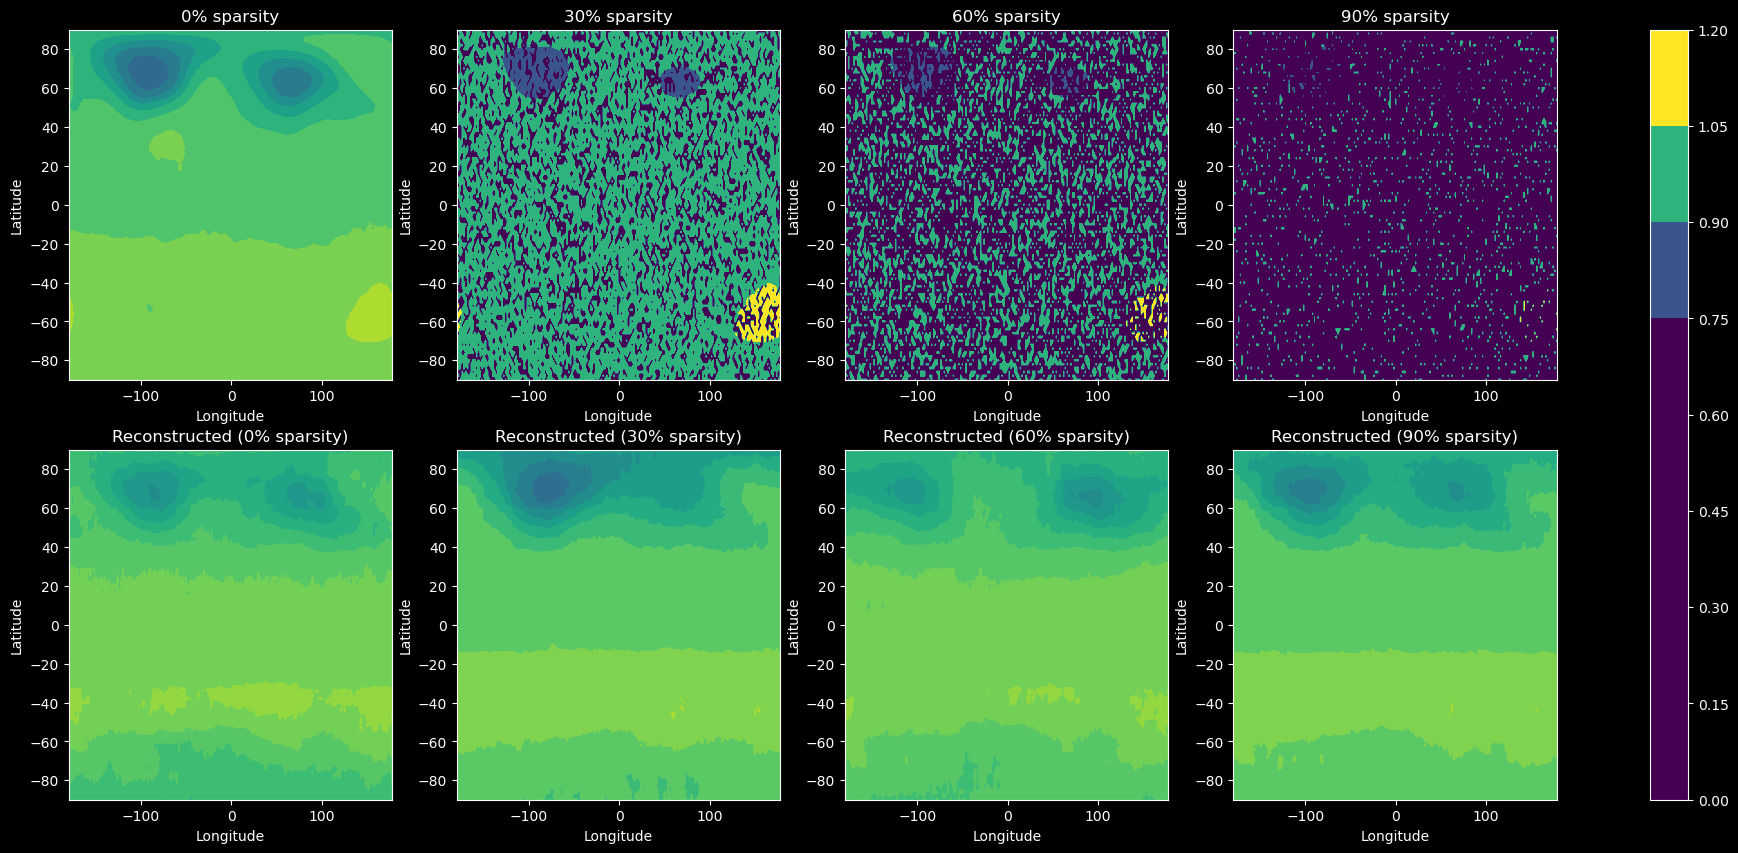

In [9]:
# sample_images should have form:
# {
#   0: (orig_0, recon_0),
#   30: (corr_30, recon_30),
#   60: (corr_60, recon_60),
#   90: (corr_90, recon_90)
# }

print(sample_images.keys()) # print to verify keys

# Create a figure with 2 rows and N columns, where N is the number of sparsities (including 0)
sorted_sparsities = sample_images.keys() # [0, 30, 60, 90]
# top row will be the input data from 0% to 90% sparsity
# bottom row will be the reconstructed data for that sparsity level
fig, axes = plt.subplots(nrows=2, ncols=len(sorted_sparsities), figsize=(6 * len(sorted_sparsities), 10))

# We'll use the same lon_grid, lat_grid, and vmin/vmax from earlier

for i, sparsity in enumerate(sorted_sparsities):
    # Unpack the top-row data (original or corrupted) and the reconstruction
    top_data, recon_data = sample_images[sparsity]
    top_title = f"{sparsity}% sparsity"

    # ---- TOP ROW ----
    cs_top = axes[0, i].contourf(
        lon_grid,
        lat_grid,
        top_data[0, :, :] if top_data.ndim == 3 else top_data,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )
    axes[0, i].set_title(top_title)
    axes[0, i].set_xlabel('Longitude')
    axes[0, i].set_ylabel('Latitude')

    # ---- BOTTOM ROW (Reconstructed) ----
    cs_bottom = axes[1, i].contourf(
        lon_grid,
        lat_grid,
        recon_data[0, :, :] if recon_data.ndim == 3 else recon_data,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )
    axes[1, i].set_title(f"Reconstructed ({sparsity}% sparsity)")
    axes[1, i].set_xlabel('Longitude')
    axes[1, i].set_ylabel('Latitude')

# Add a colorbar based on the 0% sparse data for consistency
fig.colorbar(cs_top, ax=axes, orientation='vertical')


plt.savefig(f"plots/reconstruction_comparison{timestamp}.png")
plt.show()
plt.close()